In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

import sys
from pathlib import Path

sys.path.append(str(Path('..')))

from sionna.fec.ldpc import QLDPCBPDecoder, Feedback_GNN, load_weights 
from sionna.fec.ldpc import Sandwich_BP_GNN_Evaluation_Model 
from sionna.fec.ldpc import *
from sionna.fec.utils import int_mod_2
from sionna.utils.plotting import PlotBER

from tqdm.notebook import tqdm

Number of GPUs available : 1
Only GPU number 0 used.


In [9]:
GHP_n1270_k28 = create_QC_GHP_codes(127, np.array([[0,-1,51,52,-1],[-1,0,-1,111,20],[0,-1,98,-1,122],[0,80,-1,119,-1],[-1,0,5,-1,106]]), [0,1,7], name="GHP_n1270_k28") # 16 <= d <= 46
code = GHP_n1270_k28

ber_plot = PlotBER()

bs = tf.constant(5000) # please change batch size to best fit into your gpu, now it takes 23G on my 4090
n = tf.constant(code.N)
cn_z = tf.constant(code.hz.shape[0])
cn_x = tf.constant(code.hx.shape[0])

G = Feedback_GNN(code=code, 
                 num_msg_dims=tf.constant(20),
                 num_hidden_units=tf.constant(40),
                 num_mlp_layers=2,
                 reduce_op="mean",     
                 activation="tanh",
                 use_bias=True)
G((tf.zeros((bs, n, 3)), tf.zeros((cn_x, bs)), tf.zeros((cn_z, bs)), 
                  tf.zeros((cn_x, bs)), tf.zeros((cn_z, bs))))
load_weights(G, f"../sionna/fec/ldpc/weights/feedback_GNN_n1270_k28_wt_10_80_iter_64_16_mixed.npy") 

G_coarse = Feedback_GNN(code=code, 
                 num_msg_dims=tf.constant(20),
                 num_hidden_units=tf.constant(40),
                 num_mlp_layers=2,
                 reduce_op="mean",     
                 activation="tanh",
                 use_bias=True)
G_coarse((tf.zeros((bs, n, 3)), tf.zeros((cn_x, bs)), tf.zeros((cn_z, bs)), 
                  tf.zeros((cn_x, bs)), tf.zeros((cn_z, bs))))
load_weights(G_coarse, f"../sionna/fec/ldpc/weights/feedback_GNN_n1270_k28_wt_10_60_iter_16_16.npy") 


In [3]:
num_iter1 = tf.constant(64)
num_iter2 = tf.constant(16)
factor1 = tf.constant(1.0)
factor2 = tf.constant(1.0)

decoder1 = QLDPCBPDecoder(code=code, num_iter=num_iter1, normalization_factor=factor1, cn_type="boxplus-phi", trainable=False, stage_one=True)
decoder2 = QLDPCBPDecoder(code=code, num_iter=num_iter2, normalization_factor=factor2, cn_type="boxplus-phi", trainable=False, stage_one=True)


model_eval = Sandwich_BP_GNN_Evaluation_Model(code, [decoder1]+[decoder2]*3, [G]*3, num_layers=4)
p = np.arange(0.07, 0.141, 0.01)[::-1] 
ber_plot.simulate(model_eval,
              ebno_dbs=p,
              batch_size=bs,
              num_target_block_errors=100, 
              legend=f"feedback GNN {factor1.numpy():.2f} (64,G,16,G,16,G,16)",
              soft_estimates=True,
              max_mc_iter=30000, 
              early_stop=True, 
              add_bler=True, 
              show_fig=False, 
              qldpc=True,
              forward_keyboard_interrupt=False)

Tracing MLP for num_units=ListWrapper([<tf.Tensor: shape=(), dtype=int32, numpy=40>, <tf.Tensor: shape=(), dtype=int32, numpy=20>]), input shape=(None, 3810, 4), input type=<class 'tensorflow.python.framework.ops.Tensor'>.
Tracing MLP for num_units=ListWrapper([<tf.Tensor: shape=(), dtype=int32, numpy=40>, <tf.Tensor: shape=(), dtype=int32, numpy=20>]), input shape=(None, 3810, 4), input type=<class 'tensorflow.python.framework.ops.Tensor'>.
Tracing reduce msg in update VN embedding for msg shape=(None, 3810, 20)
Tracing MLP for num_units=ListWrapper([<tf.Tensor: shape=(), dtype=int32, numpy=40>, <tf.Tensor: shape=(), dtype=int32, numpy=20>]), input shape=(None, 1270, 43), input type=<class 'tensorflow.python.framework.ops.Tensor'>.
        p |    Flagged |       BLER | flag errors | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     0.14 | 3.97

(<tf.Tensor: shape=(8,), dtype=float64, numpy=
 array([3.97200000e-01, 1.41000000e-01, 2.78000000e-02, 4.24000000e-03,
        3.63636364e-04, 3.57781753e-05, 5.76867609e-06, 1.23624675e-06])>,
 <tf.Tensor: shape=(8,), dtype=float64, numpy=
 array([3.97200000e-01, 1.41000000e-01, 2.78000000e-02, 4.24000000e-03,
        3.63636364e-04, 3.57781753e-05, 5.76867609e-06, 1.23624675e-06])>)

## Do two more rounds of feedback to further push down the error floor. 

In [4]:
num_iter1 = tf.constant(64)
num_iter2 = tf.constant(16)
factor1 = tf.constant(1.0)
factor2 = tf.constant(1.0)

decoder1 = QLDPCBPDecoder(code=code, num_iter=num_iter1, normalization_factor=factor1, cn_type="boxplus-phi", trainable=False, stage_one=True)
decoder2 = QLDPCBPDecoder(code=code, num_iter=num_iter2, normalization_factor=factor2, cn_type="boxplus-phi", trainable=False, stage_one=True)


model_eval = Sandwich_BP_GNN_Evaluation_Model(code, [decoder1]+[decoder2]*5, [G]*5, num_layers=6)
p = np.arange(0.08, 0.141, 0.01)[::-1] 
ber_plot.simulate(model_eval,
              ebno_dbs=p,
              batch_size=bs,
              num_target_block_errors=100, 
              legend=f"feedback GNN {factor1.numpy():.2f} (64,G,16,G,16,G,16,G,16,G)",
              soft_estimates=True,
              max_mc_iter=30000, 
              early_stop=True, 
              add_bler=True, 
              show_fig=False, 
              qldpc=True,
              forward_keyboard_interrupt=False)

        p |    Flagged |       BLER | flag errors | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     0.14 | 3.6540e-01 | 3.6540e-01 |        1827 |         1827 |        5000 |        13.6 |reached target block errors
     0.13 | 1.1400e-01 | 1.1400e-01 |         570 |          570 |        5000 |         1.1 |reached target block errors
     0.12 | 2.2200e-02 | 2.2200e-02 |         111 |          111 |        5000 |         1.1 |reached target block errors
     0.11 | 2.9250e-03 | 2.9250e-03 |         117 |          117 |       40000 |         9.1 |reached target block errors
      0.1 | 2.0612e-04 | 2.0612e-04 |         101 |          101 |      490000 |       110.6 |reached target block errors
     0.09 | 1.8265e-05 | 1.8265e-05 |         100 |          100 |     5475000 |      1229.1 |reached target block errors
     0.08 | 2.8301e-06 | 2.

(<tf.Tensor: shape=(7,), dtype=float64, numpy=
 array([3.65400000e-01, 1.14000000e-01, 2.22000000e-02, 2.92500000e-03,
        2.06122449e-04, 1.82648402e-05, 2.83005519e-06])>,
 <tf.Tensor: shape=(7,), dtype=float64, numpy=
 array([3.65400000e-01, 1.14000000e-01, 2.22000000e-02, 2.92500000e-03,
        2.06122449e-04, 1.82648402e-05, 2.83005519e-06])>)

## Now change the normalization factor of the first stage BP decoder to $0.8$. This gives better BLER at high $p$. However, error floor occurs at a higher block error rate compared to using factor $1.0$.

In [5]:
num_iter1 = tf.constant(64)
num_iter2 = tf.constant(16)
factor1 = tf.constant(0.8)
factor2 = tf.constant(1.0)

decoder1 = QLDPCBPDecoder(code=code, num_iter=num_iter1, normalization_factor=factor1, cn_type="boxplus-phi", trainable=False, stage_one=True)
decoder2 = QLDPCBPDecoder(code=code, num_iter=num_iter2, normalization_factor=factor2, cn_type="boxplus-phi", trainable=False, stage_one=True)


model_eval = Sandwich_BP_GNN_Evaluation_Model(code, [decoder1]+[decoder2]*3, [G]*3, num_layers=4)
p = np.arange(0.09, 0.141, 0.01)[::-1]
ber_plot.simulate(model_eval,
              ebno_dbs=p,
              batch_size=bs,
              num_target_block_errors=100, 
              legend=f"feedback GNN {factor1.numpy():.2f} (64,G,16,G,16,G,16)",
              soft_estimates=True,
              max_mc_iter=6000,
              early_stop=True, 
              add_bler=True, 
              show_fig=False, 
              qldpc=True,
              forward_keyboard_interrupt=False)

Tracing MLP for num_units=ListWrapper([<tf.Tensor: shape=(), dtype=int32, numpy=40>, <tf.Tensor: shape=(), dtype=int32, numpy=20>]), input shape=(None, 3810, 4), input type=<class 'tensorflow.python.framework.ops.Tensor'>.
Tracing MLP for num_units=ListWrapper([<tf.Tensor: shape=(), dtype=int32, numpy=40>, <tf.Tensor: shape=(), dtype=int32, numpy=20>]), input shape=(None, 3810, 4), input type=<class 'tensorflow.python.framework.ops.Tensor'>.
Tracing reduce msg in update VN embedding for msg shape=(None, 3810, 20)
Tracing MLP for num_units=ListWrapper([<tf.Tensor: shape=(), dtype=int32, numpy=40>, <tf.Tensor: shape=(), dtype=int32, numpy=20>]), input shape=(None, 1270, 43), input type=<class 'tensorflow.python.framework.ops.Tensor'>.
        p |    Flagged |       BLER | flag errors | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     0.14 | 2.46

(<tf.Tensor: shape=(6,), dtype=float64, numpy=
 array([2.46000000e-01, 6.54000000e-02, 8.13333333e-03, 7.14285714e-04,
        1.36486486e-04, 3.33333333e-05])>,
 <tf.Tensor: shape=(6,), dtype=float64, numpy=
 array([2.46000000e-01, 6.54000000e-02, 8.13333333e-03, 7.14285714e-04,
        1.36486486e-04, 3.33333333e-05])>)

In [7]:
num_iter1 = tf.constant(64)
num_iter2 = tf.constant(16)
factor1 = tf.constant(0.8)
factor2 = tf.constant(1.0)

decoder1 = QLDPCBPDecoder(code=code, num_iter=num_iter1, normalization_factor=factor1, cn_type="boxplus-phi", trainable=False, stage_one=True)
decoder2 = QLDPCBPDecoder(code=code, num_iter=num_iter2, normalization_factor=factor2, cn_type="boxplus-phi", trainable=False, stage_one=True)


model_eval = Sandwich_BP_GNN_Evaluation_Model(code, [decoder1]+[decoder2]*5, [G]*5, num_layers=6)
p = np.arange(0.09, 0.141, 0.01)[::-1]
ber_plot.simulate(model_eval,
              ebno_dbs=p,
              batch_size=bs,
              num_target_block_errors=100, 
              legend=f"feedback GNN {factor1.numpy():.2f} (64,G,16,G,16,G,16,G,16,G,16)",
              soft_estimates=True,
              max_mc_iter=6000,
              early_stop=True, 
              add_bler=True,
              show_fig=False,
              qldpc=True,
              forward_keyboard_interrupt=False)

        p |    Flagged |       BLER | flag errors | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     0.14 | 2.2780e-01 | 2.2780e-01 |        1139 |         1139 |        5000 |        14.8 |reached target block errors
     0.13 | 5.4800e-02 | 5.4800e-02 |         274 |          274 |        5000 |         1.1 |reached target block errors
     0.12 | 7.4667e-03 | 7.4667e-03 |         112 |          112 |       15000 |         3.4 |reached target block errors
     0.11 | 7.1034e-04 | 7.1034e-04 |         103 |          103 |      145000 |        32.6 |reached target block errors
      0.1 | 1.0919e-04 | 1.0919e-04 |         101 |          101 |      925000 |       207.4 |reached target block errors
     0.09 | 2.6420e-05 | 2.6420e-05 |         100 |          100 |     3785000 |       853.1 |reached target block errors


(<tf.Tensor: shape=(6,), dtype=float64, numpy=
 array([2.27800000e-01, 5.48000000e-02, 7.46666667e-03, 7.10344828e-04,
        1.09189189e-04, 2.64200793e-05])>,
 <tf.Tensor: shape=(6,), dtype=float64, numpy=
 array([2.27800000e-01, 5.48000000e-02, 7.46666667e-03, 7.10344828e-04,
        1.09189189e-04, 2.64200793e-05])>)

### Use $G_{coarse}$ to do the evaluation.

In [3]:
num_iter1 = tf.constant(64)
num_iter2 = tf.constant(16)
factor1 = tf.constant(1.0)
factor2 = tf.constant(1.0)

decoder1 = QLDPCBPDecoder(code=code, num_iter=num_iter1, normalization_factor=factor1, cn_type="boxplus-phi", trainable=False, stage_one=True)
decoder2 = QLDPCBPDecoder(code=code, num_iter=num_iter2, normalization_factor=factor2, cn_type="boxplus-phi", trainable=False, stage_one=True)


model_eval = Sandwich_BP_GNN_Evaluation_Model(code, [decoder1,decoder2], [G_coarse], num_layers=2)
p = np.arange(0.02, 0.141, 0.01)[::-1] 
ber_plot.simulate(model_eval,
              ebno_dbs=p,
              batch_size=bs,
              num_target_block_errors=100, 
              legend=f"feedback GNN {factor1.numpy():.2f} (64,G_coarse,16)",
              soft_estimates=True,
              max_mc_iter=30000, 
              early_stop=True, 
              add_bler=True, 
              show_fig=False, 
              qldpc=True,
              forward_keyboard_interrupt=False)

        p |    Flagged |       BLER | flag errors | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     0.14 | 4.6660e-01 | 4.6660e-01 |        2333 |         2333 |        5000 |         7.9 |reached target block errors
     0.13 | 2.1060e-01 | 2.1060e-01 |        1053 |         1053 |        5000 |         0.5 |reached target block errors
     0.12 | 7.3000e-02 | 7.3000e-02 |         365 |          365 |        5000 |         0.5 |reached target block errors
     0.11 | 2.5800e-02 | 2.5800e-02 |         129 |          129 |        5000 |         0.5 |reached target block errors
      0.1 | 7.1333e-03 | 7.1333e-03 |         107 |          107 |       15000 |         1.4 |reached target block errors
     0.09 | 2.5500e-03 | 2.5500e-03 |         102 |          102 |       40000 |         3.7 |reached target block errors
     0.08 | 1.3600e-03 | 1.

(<tf.Tensor: shape=(13,), dtype=float64, numpy=
 array([4.66600000e-01, 2.10600000e-01, 7.30000000e-02, 2.58000000e-02,
        7.13333333e-03, 2.55000000e-03, 1.36000000e-03, 7.06666667e-04,
        3.74074074e-04, 1.78571429e-04, 8.58369099e-05, 5.84795322e-05,
        1.96850394e-05])>,
 <tf.Tensor: shape=(13,), dtype=float64, numpy=
 array([4.66600000e-01, 2.10600000e-01, 7.30000000e-02, 2.58000000e-02,
        7.13333333e-03, 2.55000000e-03, 1.36000000e-03, 7.06666667e-04,
        3.74074074e-04, 1.78571429e-04, 8.58369099e-05, 5.84795322e-05,
        1.96850394e-05])>)

## Load dataset and plot LLRs.

In [6]:
dataset_x = tf.data.Dataset.from_tensor_slices(np.load("../sionna/fec/ldpc/datasets/n1270_k28_wt_10_80_x_all.npy"))
dataset_z = tf.data.Dataset.from_tensor_slices(np.load("../sionna/fec/ldpc/datasets/n1270_k28_wt_10_80_z_all.npy"))                                              
dataset = tf.data.Dataset.zip((dataset_x, dataset_z))
dataset_size = dataset.cardinality()
print("datase size", dataset_size)
dataset = dataset.shuffle(dataset_size, reshuffle_each_iteration=True)
dataset = dataset.batch(200)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

decoder1 = QLDPCBPDecoder(code=code, num_iter=64, normalization_factor=1.0, cn_type="boxplus-phi", trainable=False, stage_one=True)

datase size tf.Tensor(1307084, shape=(), dtype=int64)


first stage output llr max [53.9496498 103.856247 53.9496498]
first stage output llr min [-45.8635445 -95.7701416 -45.8635445]
first stage output llr mean [50.8812599 97.5885391 50.7503624]
new llr max [2.00996542 2.33599687 1.94496477]
new llr min [0.187279522 0.486101151 0.396793604]
new llr mean [1.53385437 2.01246786 1.82028031]


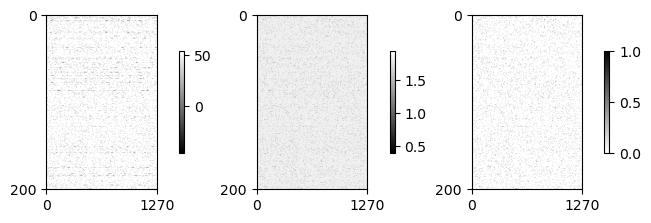

In [7]:
for noise_x, noise_z in dataset.take(1):
    noise_x_T, noise_z_T = tf.transpose(noise_x, (1,0)), tf.transpose(noise_z, (1,0))
    noise_x_int = tf.cast(noise_x_T, code.hz.dtype)
    noise_z_int = tf.cast(noise_z_T, code.hx.dtype)
    syndrome_x = int_mod_2(tf.matmul(code.hx, noise_z_int))
    syndrome_z = int_mod_2(tf.matmul(code.hz, noise_x_int))

    p0 = 0.05 # instead of p0 = p
    llr_ch_x = tf.fill(tf.shape(noise_x), tf.math.log(3.*(1.-p0)/p0))
    llr = tf.tile(tf.expand_dims(llr_ch_x, axis=1), multiples=tf.constant([1, 3, 1], tf.int32))
    # shape of llr: [bs, 3, self.n]

    llrx, llry, llrz, x_hat, z_hat, logit_hx_perp, logit_hz_perp = decoder1((llr, syndrome_x, syndrome_z))
    h_vn = tf.stack([llrx, llry, llrz], axis=-1) # [bs, n, 3]
    tf.print("first stage output llr max", tf.math.reduce_max(h_vn, axis=(0,1)))
    tf.print("first stage output llr min", tf.math.reduce_min(h_vn, axis=(0,1)))
    tf.print("first stage output llr mean", tf.math.reduce_mean(h_vn, axis=(0,1)))
    new_llr = G((h_vn, logit_hz_perp, logit_hx_perp, syndrome_x, syndrome_z)) # [bs, n, 3]
    tf.print("new llr max", tf.math.reduce_max(new_llr, axis=(0,1)))
    tf.print("new llr min", tf.math.reduce_min(new_llr, axis=(0,1)))
    tf.print("new llr mean", tf.math.reduce_mean(new_llr, axis=(0,1)))
    llr_max = tf.math.reduce_max(new_llr, axis=(0,1))

    fig, ax = plt.subplots(1, 3, constrained_layout = True)
    im = ax[0].imshow(h_vn[:,:,2]   , aspect=10, cmap='gist_gray')#, interpolation='none')
    ax[0].xaxis.set_ticks([0,1270])
    ax[0].yaxis.set_ticks([0,200])
    plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)
    im = ax[1].imshow(new_llr[:,:,2], aspect=10, cmap='gist_gray')#, interpolation='none')#, vmin=0.4, vmax=1.5)
    ax[1].xaxis.set_ticks([0,1270])
    ax[1].yaxis.set_ticks([0,200])
    plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
    im = ax[2].imshow(noise_z       , aspect=10, cmap='gist_yarg')#, interpolation='none')
    ax[2].xaxis.set_ticks([0,1270])
    ax[2].yaxis.set_ticks([0,200])
    plt.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
#     plt.savefig('pattern.pdf', format='pdf', bbox_inches='tight')
